In [1]:
%reset -f
import glob, os, sys, io
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
from wavhandler import *
from utils import *
import multiprocessing

import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)

In [226]:
def get_psd(fname, data, plot=False):
    # BANDPASS FILTERING
    sig_bandpass = butter_bandpass_filter(data=data, lowcut=L_CUTOFF, highcut=H_CUTOFF, fs=F_S, order=B_ORDER)
    # CROPPING
    sig_cropped = crop_signal(sig_bandpass, window=300, intens_threshold=0.0004, offset=200)

    if sig_cropped is None or sig_cropped.empty or len(sig_cropped) < 256:
        return pd.Series(np.ones(2500,)*np.nan)
    
    try:# POWER SPECTRAL DENSITY
        psd = psd_process(sig_cropped, fs=F_S, scaling='density', window='hamming', nperseg=256, noverlap=128+64, crop_hz=2500)#, nfft=8192)
    except:
        print(len(sig_cropped))
        raise ValueError('Wrong things happened')
    
    psd[fname] = psd.pow_amp
    return psd[fname]

def process_parallel(path):
    data, _ = read_simple([path])
    fname = path.split('/')[-1][:-4]
    return get_psd(fname, data)

def make_insect_df(df, insect_class='Culex', names=[]):
    print('Setting the number of cores..')
    try:
        cpus = multiprocessing.cpu_count()
    except NotImplementedError:
        cpus = 2   # arbitrary default

    print('Gathering all files for selected class..')
    names = df[df.label1==insect_class].names.tolist()
    names = random.sample(names, 5000) # HERE YOU SELECT SAMPLE SIZE

    print('Creating pool for parallel processes..')
    pool = multiprocessing.Pool(processes=cpus)
    print('Calculating..')
    result_list = []
    result_list.append(pool.map(process_parallel, names))
    print('Creating Dataframe..')
    df = pd.concat(result_list[0], axis=1, sort=False)
    print('Done.\n')
    return df

In [227]:
df_mosquitos = pd.read_pickle('./data/mosquitos.pkl')

# Creating dataframes that contain PSDs for each insect class

In [228]:
df_an = make_insect_df(df_mosquitos, insect_class='Anopheles').T
df_an['label'] = 'an'
df_ae = make_insect_df(df_mosquitos, insect_class='Aedes').T
df_ae['label'] = 'ae'
df_cu = make_insect_df(df_mosquitos, insect_class='Culex').T
df_cu['label'] = 'cu'

Setting the number of cores..
Gathering all files for selected class..
Creating pool for parallel processes..
Calculating..
Creating Dataframe..
Done.

Setting the number of cores..
Gathering all files for selected class..
Creating pool for parallel processes..
Calculating..
Creating Dataframe..
Done.

Setting the number of cores..
Gathering all files for selected class..
Creating pool for parallel processes..
Calculating..
Creating Dataframe..
Done.



In [229]:
df_concat = pd.concat([df_ae, df_an, df_cu], axis=0, sort=False)
labelarray = df_concat.label.values
df_concat.drop('label', axis=1, inplace=True)
print(df_concat.shape)
df_concat.dropna(how='all', axis=1, inplace=True)
df_concat.dropna(how='all', axis=0, inplace=True)
print(df_concat.shape)
df_concat.head()

(15000, 2500)
(14995, 129)


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
F170102_203902_070_G_050,0.009134,0.094896,0.005225,0.000103,0.000091,0.000067,0.000085,0.000065,0.000043,0.000047,...,0.000038,0.000053,0.000059,0.000029,0.000015,0.000011,0.000007,0.000008,0.000009,0.000005
F170103_165218_180_G_050,0.033601,0.649656,0.016797,0.001200,0.000660,0.000599,0.000591,0.000499,0.000555,0.000511,...,0.000050,0.000094,0.000086,0.000082,0.000099,0.000185,0.000111,0.000081,0.000092,0.000031
F170208_213050_254_G_050,0.012228,0.098171,0.015433,0.000823,0.000264,0.000222,0.000214,0.000164,0.000170,0.000094,...,0.000027,0.000037,0.000040,0.000030,0.000044,0.000052,0.000036,0.000046,0.000105,0.000061
F170209_125748_242_G_050,0.003851,0.043463,0.003121,0.000472,0.000281,0.000223,0.000187,0.000156,0.000147,0.000112,...,0.000065,0.000079,0.000056,0.000072,0.000064,0.000061,0.000047,0.000046,0.000039,0.000020
F170209_124450_041_G_050,0.048890,0.373033,0.188529,0.109417,0.076007,0.035422,0.023425,0.027491,0.020751,0.012577,...,0.000128,0.000153,0.000075,0.000071,0.000075,0.000070,0.000075,0.000124,0.000104,0.000031


### Example PSD

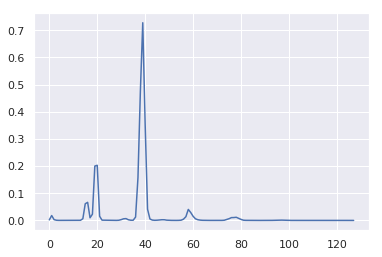

In [230]:
df_concat.iloc[9,:-1].plot()

# Principal Component Analysis

In [231]:
X = df_concat.iloc[:,:-1].values

In [241]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

idx = np.random.randint(X.shape[0], size=3000)
X = X[idx,:]
labelarray = labelarray[idx]
X_std = StandardScaler(with_std=False).fit_transform(X);  # standardization of data

pca = PCA(n_components=13) # 10 to get 80% explained variance
Χ_final = pca.fit_transform(X_std)
print("EXPLAINED VARIANCE: {0:.2f}".format(pca.explained_variance_ratio_.sum()) )

EXPLAINED VARIANCE: 0.82


## Plotting PCA scores (The first two components)

Text(0, 0.5, 'component 2')

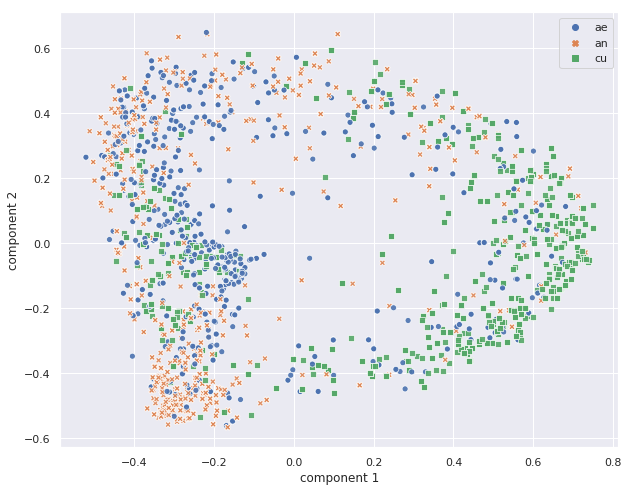

In [242]:


plt.figure(figsize=(10,8))
sns.scatterplot(Χ_final[:,0], Χ_final[:,1], hue=labelarray, style=labelarray, alpha=0.9)
plt.xlabel('component 1')
plt.ylabel('component 2')


In [234]:
df_pca = pd.DataFrame(pca.components_,index = ['PC-1','PC-2', 'PC-3'])
df_pca

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
PC-1,-0.022615,-0.234609,-0.015492,0.001369,0.001166,0.000715,0.000403,0.000306,0.000299,0.000409,...,-0.000061,-0.000051,-0.000051,-0.000061,-0.000075,-0.000068,-0.000065,-0.000060,-0.000057,-0.000055
PC-2,-0.027715,-0.295351,-0.022111,-0.001420,-0.000866,-0.000599,-0.000456,-0.000359,-0.000334,-0.000422,...,-0.000061,-0.000054,-0.000065,-0.000089,-0.000102,-0.000084,-0.000076,-0.000073,-0.000067,-0.000070
PC-3,-0.045733,-0.436480,-0.042991,-0.002754,-0.000737,-0.000423,-0.000338,-0.000286,-0.000268,-0.000179,...,0.000010,0.000007,-0.000011,-0.000034,-0.000033,-0.000016,-0.000010,-0.000010,-0.000006,-0.000014


In [235]:
pca.components_.shape

(3, 128)

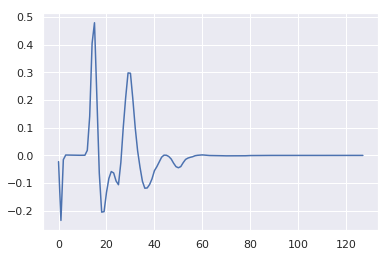

In [236]:
df_pca.loc['PC-1'].plot()

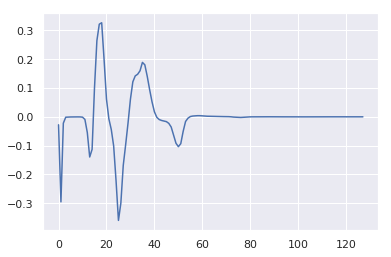

In [237]:
df_pca.loc['PC-2'].plot()

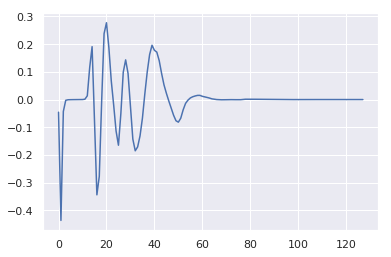

In [238]:
df_pca.loc['PC-3'].plot()

# 3D Plot (PCA scores, 3 components)

In [239]:
import plotly
import plotly.plotly as py
from sklearn.preprocessing import LabelEncoder
plotly.tools.set_credentials_file(username='kalfasyan', api_key='oOr9ILFmszXQYREloJTp')

import plotly.graph_objs as go

import numpy as np

x, y, z = Χ_final[:,0], Χ_final[:,1], Χ_final[:,2]
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=4,
        line=dict(
            color=LabelEncoder().fit(['cu','an','ae']).transform(labelarray),#'rgba(217, 217, 217, 0.14)',
            colorscale='Portland',
            width=0.5
        ),
        opacity=0.7
    )
)


data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

/home/yannis/.virtualenvs/wingbeat_frequencies/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



array([0, 2, 2, ..., 0, 0, 1])

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(Χ_final)


import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='kalfasyan', api_key='oOr9ILFmszXQYREloJTp')

import plotly.graph_objs as go

import numpy as np

x, y, z = Χ_final[:,0], Χ_final[:,1], Χ_final[:,2]
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=1,
        line=dict(
            color=kmeans.labels_,#'rgba(217, 217, 217, 0.14)',
            colorscale='Viridis',
            width=0.5
        ),
        opacity=0.9
    )
)


data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

# Edw eisai

In [ ]:
df_an = df_an.transpose()
df_an.shape

In [ ]:
df_an['kmeans'] = kmeans.labels_

In [ ]:
df_an.sample(10)

In [ ]:
import pickle

def save_obj(obj, name ):
    with open('./data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
save_obj(df_an['kmeans'].to_dict(), 'df_an_clusters')